In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import lbmio
import tifffile
from scipy import signal

In [4]:
# Create the job
job = Job('/mnt/md0/runs','Demo-GPU', create=False, overwrite=False, verbosity = 3)
tif_path = job.tifs[0]

   Found and loaded params from /mnt/md0/runs/s3d-Demo-GPU/params.npy


In [6]:
stitched_tif = lbmio.load_and_stitch_tifs([tif_path], planes = job.params['planes'])

Loading /mnt/md0/data/demo/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif
Loaded 1 files, total 6.82 GB


In [8]:
tif = tifffile.imread(tif_path)
line_mov_vol = tif.mean(axis=-1)

fill_fraction = tfu.get_tif_tag(tif_path,'SI.hScan2D.fillFractionTemporal ',number=True)
sample_rate = tfu.get_tif_tag(tif_path,'SI.hScan2D.sampleRate ',number=True)
scanner_freq = tfu.get_tif_tag(tif_path,'SI.hScan2D.scannerFrequency', number=True)
line_freq = 2 * scanner_freq
flyto = tfu.get_tif_tag(tif_path,'SI.hScan2D.flytoTimePerScanfield ', number=True)
flyback = tfu.get_tif_tag(tif_path,'SI.hScan2D.flybackTimePerFrame ', number=True)
vol_rate = tfu.get_vol_rate(tif_path)

In [54]:
plane_idx = 10

line_mov = line_mov_vol[:,plane_idx]

In [55]:
plane_mov = stitched_tif[plane_idx]

napari.view_image(plane_mov)

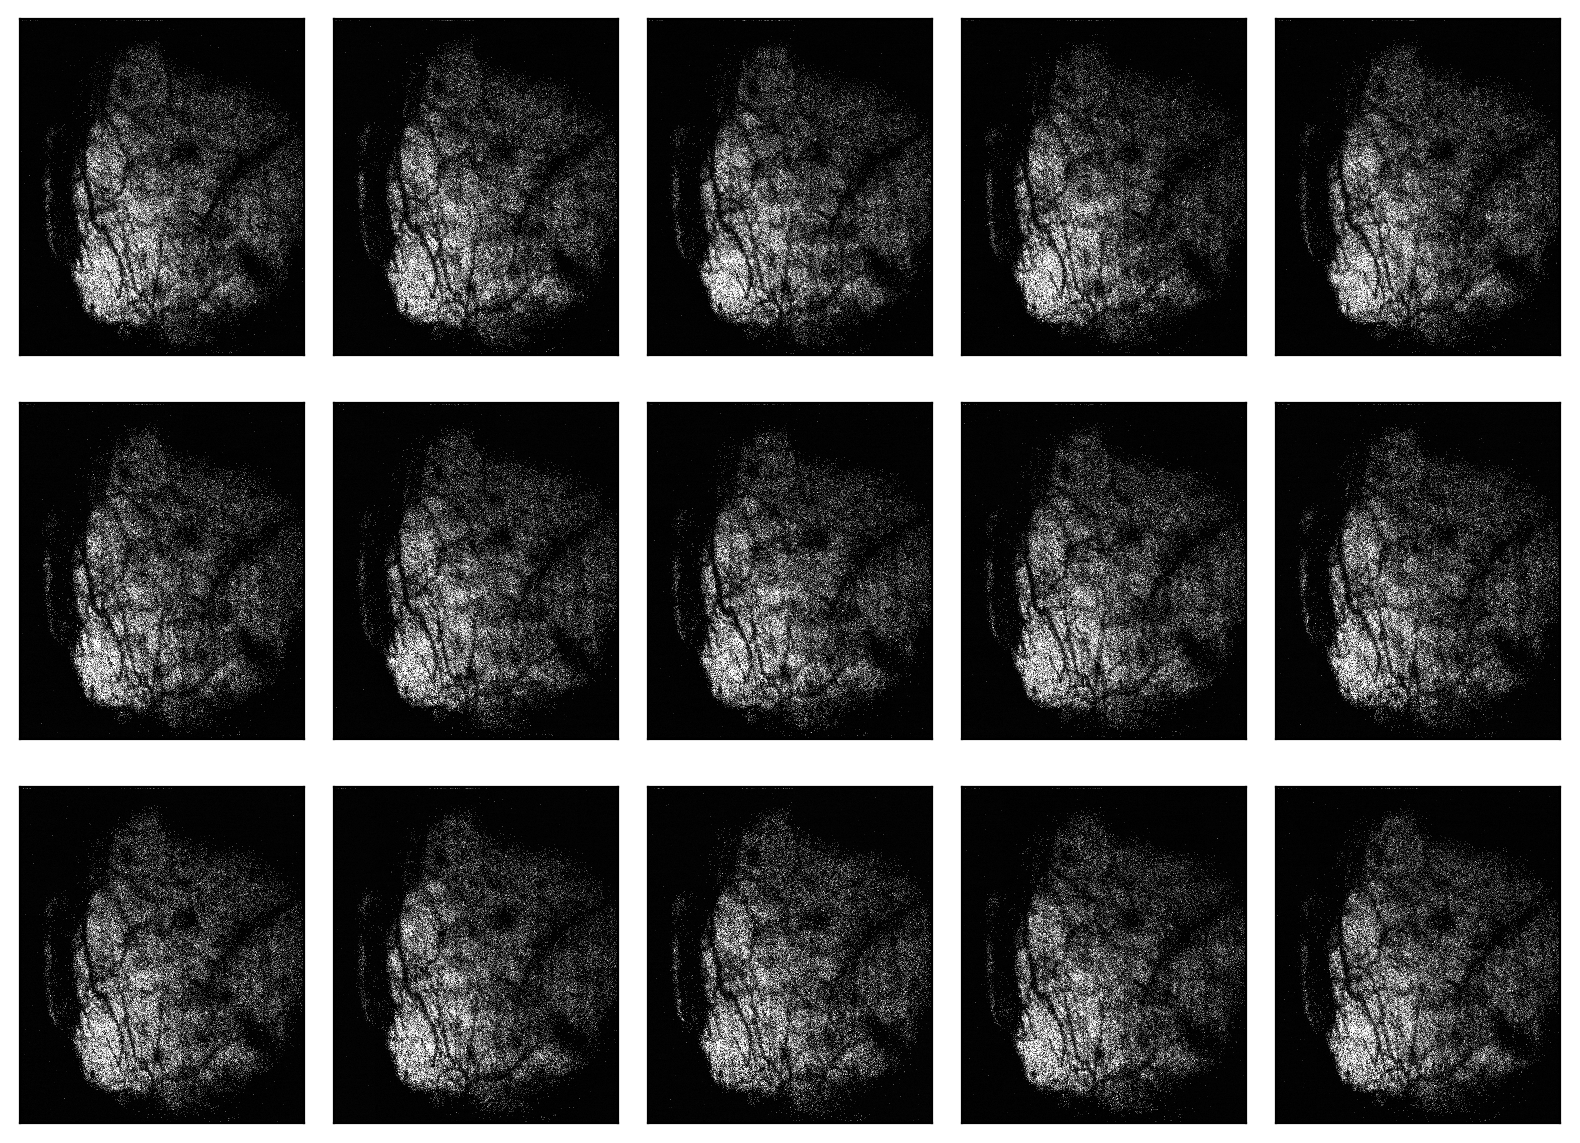

In [71]:
tidx = 29
f,axs = plt.subplots(3,5, figsize=(8,6), dpi=200)
for i in range(len(axs)):
    for j in range(len(axs[0])):
        tfu.show_tif(plane_mov[tidx], ax=axs[i][j])
        tidx += 1
plt.tight_layout()

In [72]:
nt, n_lines = line_mov.shape
line_f = line_mov.reshape(-1)
vol_scan_time = n_lines * 1/line_freq
vol_period = 1/vol_rate
inferred_flyback = vol_period - vol_scan_time
n_pad = int(n.round(inferred_flyback * line_freq))

line_mov_pad = n.zeros((line_mov.shape[0],line_mov.shape[1] + n_pad))
line_mov_pad[:,:n_lines] = line_mov
line_pad_f = line_mov_pad.flatten()

(0.1, 1000.0)

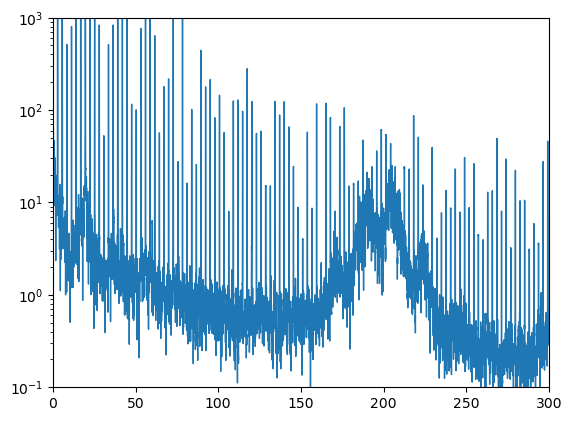

In [96]:
f, Pxx_den = signal.periodogram(line_pad_f, line_freq)

plt.semilogy(f, utils.moving_average(Pxx_den,5), linewidth=1)
# plt.xlim(150,250)
plt.xlim(0,300)
plt.ylim(1e-1,1e3)

In [99]:
fs = line_freq  # Sample frequency (Hz)
f0 = 200  # Frequency to be removed from signal (Hz)
Q = 5 # Quality factor
# Design notch filter
b, a = signal.iirnotch(f0, Q, fs)

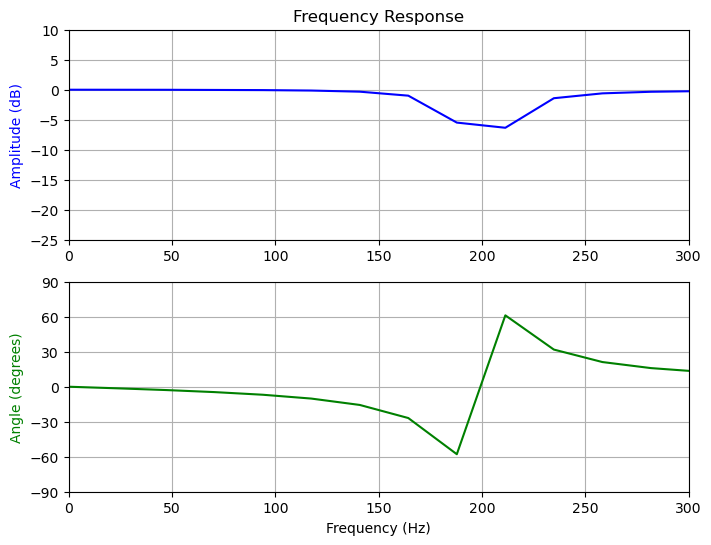

In [100]:
freq, h = signal.freqz(b, a, fs=fs)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*n.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 300])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, n.unwrap(n.angle(h))*180/n.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 300])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [101]:
line_pad_f_filt = signal.filtfilt(b,a, line_pad_f,)

In [102]:
f, Pxx_den_filt = signal.periodogram(line_pad_f_filt, line_freq)

(0.1, 1000.0)

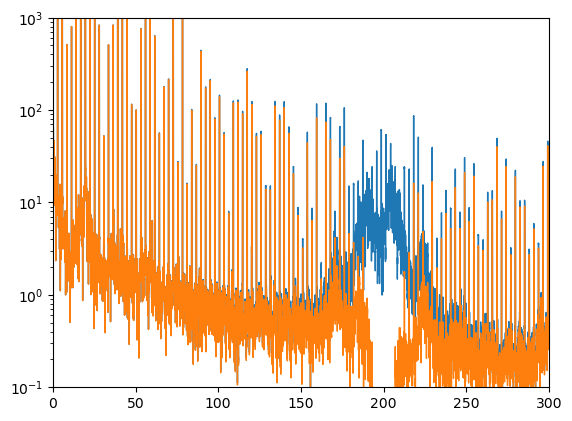

In [103]:
plt.semilogy(f, utils.moving_average(Pxx_den,5), linewidth=1)
plt.semilogy(f, utils.moving_average(Pxx_den_filt,5), linewidth=1)
# plt.xlim(150,250)
plt.xlim(0,300)
plt.ylim(1e-1,1e3)

In [105]:
stitched_tif_filt = lbmio.load_and_stitch_tifs([tif_path], planes = job.params['planes'], 
                                               filt = {'f0':200, 'Q': 5, 'line_freq' : line_freq})

Loading /mnt/md0/data/demo/AH007_ROI3p33um_NOSCREEN_-400um_00001_00001.tif
Loaded 1 files, total 6.82 GB


In [106]:
plane_mov = stitched_tif[plane_idx]
plane_mov_filt = stitched_tif_filt[plane_idx]
v = napari.view_image(plane_mov)
v.add_image(plane_mov_filt)

<Image layer 'plane_mov_filt' at 0x7f4b0b4df460>